# NLP Practical 8
> 19BCE245 - Aayush Shah

Implement the text summarization using any one of the techniques.
Theory:
Text summarization can broadly be divided into two categories — Extractive Summarization and Abstractive Summarization.
Extractive Summarization: These methods rely on extracting several parts, such as phrases and sentences, from a piece of text and stack them together to create a summary. Therefore, identifying the right sentences for summarization is of utmost importance in an extractive method.
Abstractive Summarization: These methods use advanced NLP techniques to generate an entirely new summary. Some parts of this summary may not even appear in the original text.
In this program, we implement “Text Rank” algorithm which is an Extractive summarization technique.
[*(Reference)*](https://towardsdatascience.com/text-summarization-with-nlp-textrank-vs-seq2seq-vs-bart-474943efeb09)

## Extractive method *(Text Rank with Gensim)*

In [10]:
%pip install datasets
%pip install contractions
%pip install rouge

     |████████████████████████████████| 287 kB 5.1 MB/s 
     |████████████████████████████████| 106 kB 46.7 MB/s 


In [11]:
## for data
import datasets  
import pandas as pd  
import numpy  

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns  

## for preprocessing
import re
import nltk  
import contractions

## for textrank
import gensim  

## for evaluation
import rouge  
import difflib

In [14]:
## load the full dataset of 300k articles
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')
lst_dics = [dic for dic in dataset["train"]]
## keep the first N articles if you want to keep it lite 
dtf = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y"})[["text","y"]].head(20000)
dtf.head()

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

,text,y
0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...
1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...
2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...
3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...
4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...


In [15]:
i = 1
print("--- Full text ---")
print(dtf["text"][i])
print("--- Summary ---")
print(dtf["y"][i])

--- Full text ---
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victor

In [19]:
dtf_train = dtf.iloc[i+1:]
dtf_test = dtf.iloc[:i+1]

In [24]:
'''
Summarizes corpus with TextRank.
:parameter    
    :param corpus: str or list - dtf["text"]    
    :param ratio: length of the summary (ex. 20% of the text)
:return    
    list of summaries
'''
def textrank(corpus, ratio=0.2):    
    if type(corpus) is str:        
       corpus = [corpus]    
    lst_summaries = [gensim.summarization.summarize(txt,  
                     ratio=ratio) for txt in corpus]    
    return lst_summaries

## Apply the function to corpus
# print('Original text : ', dtf_test["text"])
predicted = textrank(corpus=dtf_test["text"], ratio=0.2)
# predicted[i]

print("--- Full text ---")
print(dtf_test["text"][i])
print("--- Predicted Summary ---")
print(predicted[i])

--- Full text ---
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victor

## Abstractive method *(`Seq2Seq` neural network and Attention-based Transformers)*

In [12]:
%pip install transformers

In [48]:
## for seq2seq
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing 
## for bart
import transformers  
import nltk
nltk.download(['stopwords','wordnet','punkt'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Seq2Seq : 

In [32]:
## create stopwords
lst_stopwords = nltk.corpus.stopwords.words("english")
## add words that are too frequent
lst_stopwords = lst_stopwords + ["cnn","say","said","new"]

## cleaning function
def utils_preprocess_text(txt, punkt=True, lower=True, slang=True, lst_stopwords=None, stemm=False, lemm=True):
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt   
    ### tokenize (convert from string to list)
    lst_txt = txt.split()
    ### stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
    ### lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]
    ### remove Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in 
                   lst_stopwords]
    ### back to string
    txt = " ".join(lst_txt)
    return txt

## apply function to both text and summaries
dtf_train["text_clean"] = dtf_train["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
dtf_train["y_clean"] = dtf_train["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
# ## count
# dtf_train['word_count'] = dtf_train[column].apply(lambda x: len(nltk.word_tokenize(str(x))) )
# ## plot
# sns.distplot(dtf_train["word_count"], hist=True, kde=True, kde_kws={"shade":True})

In [43]:
X_len = 400
y_len = 40

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


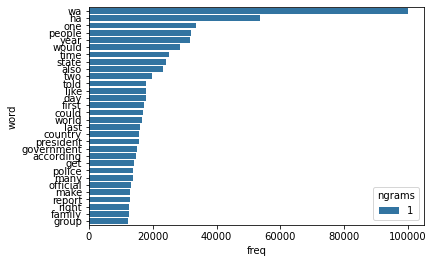

In [50]:
lst_tokens = nltk.tokenize.word_tokenize(dtf_train["text_clean"].str.cat(sep=" "))
ngrams = [1]
    
## calculate
dtf_freq = pd.DataFrame()
for n in ngrams:
   dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
   dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=
                        ["word","freq"])
   dtf_n["ngrams"] = n
   dtf_freq = dtf_freq.append(dtf_n)
   dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
   dtf_freq_X= dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
## plot
sns.barplot(x="freq", y="word", hue="ngrams", dodge=False,
 data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))
plt.show()

In [52]:
# thres = 5 #<-- min frequency
# X_top_words = len(dtf_freq_X[dtf_freq_X["freq"]>thres])
# y_top_words = len(dtf_freq_y[dtf_freq_y["freq"]>thres])

In [53]:
lst_corpus = dtf_train["text_clean"]
## tokenize text
tokenizer = kprocessing.text.Tokenizer(num_words=X_top_words, lower=False, split=' ', oov_token=None, 
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = {"<PAD>":0}
dic_vocabulary.update(tokenizer.word_index)
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

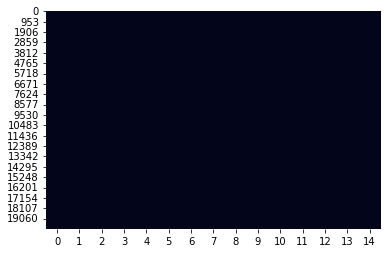

In [54]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [61]:
# ## text to sequence with the fitted tokenizer
# lst_text2seq = tokenizer.texts_to_sequences(dtf_test["text_clean"])
# ## padding sequence
# X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
#              padding="post", truncating="post")

In [60]:
# # Add START and END tokens to the summaries (y)
# special_tokens = ("<START>", "<END>")
# dtf_train["y_clean"] = dtf_train['y_clean'].apply(lambda x: 
#                      special_tokens[0]+' '+x+' '+special_tokens[1])
# dtf_test["y_clean"] = dtf_test['y_clean'].apply(lambda x: 
#                      special_tokens[0]+' '+x+' '+special_tokens[1])
# # check example
# dtf_test["y_clean"][i]

### Transformers :

In [59]:
'''
Summarizes corpus with Bart.
:parameter    
   :param corpus: list - dtf["text"]    
   :param max_len: length of the summary
:return    
    list of summaries
'''
# def bart(corpus, max_len):    
#     nlp = transformers.pipeline("summarization")    
#     lst_summaries = [nlp(txt,               
#                          max_length=max_len
#                          )[0]["summary_text"].replace(" .", ".")                    
#                      for txt in corpus]    
#     return lst_summaries

# ## Apply the function to corpus
# predicted = bart(corpus=dtf_test["text"], max_len=y_len)

'\nSummarizes corpus with Bart.\n:parameter    \n   :param corpus: list - dtf["text"]    \n   :param max_len: length of the summary\n:return    \n    list of summaries\n'